In [1]:
import os
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt


import tensorflow as tf
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Layer
from tensorflow.keras.utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

TRAIN_DF_PATH = "/kaggle/input/dataset-diabetic-eye-contrast/diabetic-eye/train/train.csv"
TEST_DF_PATH = '/kaggle/input/dataset-diabetic-eye-contrast/diabetic-eye/test/test_submission.csv'
TRAIN_IMG_PATH = "/kaggle/input/dataset-diabetic-eye-contrast/diabetic-eye/train/contrast"
TEST_IMG_PATH = '/kaggle/input/dataset-diabetic-eye-contrast/diabetic-eye/test/contrast'
SAVED_MODEL_NAME = 'effnetV2M_modelLast.h5'

seed = 42
rn.seed(seed)
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH)

# Add extension to id_code
train_df['filename'] = train_df['filename']
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)

# Add extension to id_code
test_df['filename'] = test_df['filename']
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 44343


,filename,level,target
0,im_1000.png,0,0
1,im_10000.png,0,0
2,im_10001.png,0,0
3,im_10004.png,2,1
4,im_10005.png,0,0


Image IDs (TEST)
Testing Images: 44349


,filename,target
0,im_1.png,NaN
1,im_10.png,NaN
2,im_100.png,NaN
3,im_10002.png,NaN
4,im_10003.png,NaN


In [4]:
# Specify image size
IMG_WIDTH = 512
IMG_HEIGHT = 512
CHANNELS = 3

In [5]:
def get_preds_and_labels(model, generator):
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [6]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []
    def on_epoch_end(self, epoch, logs={}):
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)

        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

In [16]:
def preprocess_image(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    return image

In [8]:
# Labels for training data
y_labels = train_df['level'].values
y_labels

array([0, 0, 0, ..., 0, 0, 0])

# EfficientNetModel

In [9]:
# Load in EfficientNet
import keras.applications as models
effnet = tf.keras.applications.EfficientNetV2M(weights="imagenet",
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))

214201816/214201816 [==============================] - 1s 0us/step


In [10]:
def build_model():
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation="softmax"))
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['acc']
             )
    print(model.summary())
    return model

# Initialize model
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 16, 16, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 53,156,793
Trainable params: 52,864,761
Non-trainable params: 292,032
_________________________________________________________________
None


In [11]:
train_df.head()

,filename,level,target
0,im_1000.png,0,0
1,im_10000.png,0,0
2,im_10001.png,0,0
3,im_10004.png,2,1
4,im_10005.png,0,0


In [17]:
train_df['level'] = train_df['level'].astype(str)

BATCH_SIZE = 8

train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.20,
                                   preprocessing_function=preprocess_image, 
                                   rescale=1 / 128.)



train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='filename', 
                                                    y_col='level',
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical', 
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='filename', 
                                                  y_col='level',
                                                  directory = TRAIN_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  subset='validation')

Found 35475 validated image filenames belonging to 5 classes.
Found 8868 validated image filenames belonging to 5 classes.


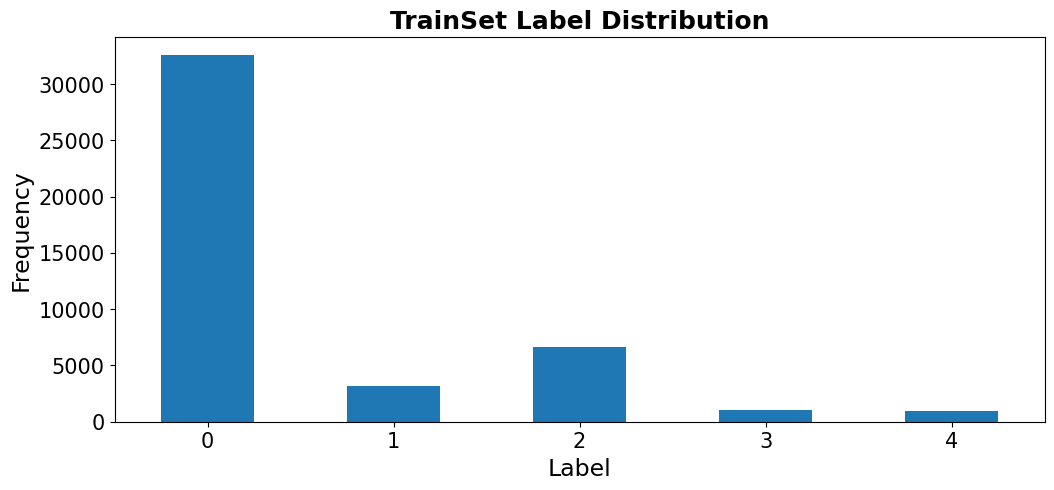

In [18]:
train_df['level'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("TrainSet Label Distribution", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

In [19]:
import math

unique = np.unique(train_df['level'], return_counts=True)
labels_dict = dict(zip(unique[0], unique[1]))
print(labels_dict)

def get_class_weight(labels_dict):
    total = sum(labels_dict.values())
    max_num = max(labels_dict.values())
    mu = 1.0 / (total / max_num)
    class_weight = dict()
    for key, value in labels_dict.items():
        score = math.log(mu * total / float(value))
        class_weight[int(key)] = score if score > 1.0 else 1.0
    return class_weight

print(get_class_weight(labels_dict))
cw = get_class_weight(labels_dict)
print(cw)

{'0': 32575, '1': 3131, '2': 6626, '3': 1059, '4': 952}
{0: 1.0, 1: 2.34219268066664, 2: 1.5925438191332046, 3: 3.426220056391639, 4: 3.5327353672016804}
{0: 1.0, 1: 2.34219268066664, 2: 1.5925438191332046, 3: 3.426220056391639, 4: 3.5327353672016804}


In [24]:
kappa_metrics = Metrics()

es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=2, 
                        verbose=1, 
                        mode='auto', 
                        min_delta=0.0001)

model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=50,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, es, rlr],class_weight=cw)

Epoch 1/50
   5/1108 [..............................] - ETA: 21:42 - loss: 1.0112 - acc: 0.8750

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/efficientnetv2-m/top_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_23/120419505.py", line 17, in <module>
      callbacks=[kappa_metrics, es, rlr],class_weight=cw)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 866, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 660, in _fused_batch_norm
      training, _fused_batch_norm_training, _fused_batch_norm_inference
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/control_flow_util.py", line 109, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/normalization/batch_normalization.py", line 644, in _fused_batch_norm_training
      exponential_avg_factor=exponential_avg_factor,
Node: 'sequential/efficientnetv2-m/top_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[8,1280,16,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/efficientnetv2-m/top_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_92728]

In [23]:
val_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

# Prediction

In [25]:
test_df['filename'] = test_df['filename']

test_generator = train_datagen.flow_from_dataframe(test_df, 
                                                    x_col='filename', 
                                                    y_col=None,
                                                    directory = TEST_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    class_mode=None,shuffle=False)
     
tta_preds = []
preds = model.predict(test_generator,5000)
tta_preds.append(preds)

Found 44349 validated image filenames.
1386/1386 [==============================] - 3870s 3s/step


In [28]:
avg_preds = tf.reduce_mean(tta_preds, axis=0)
avg_predsss = tf.argmax(avg_preds, axis=1).numpy()

In [29]:
file_names = test_generator.filenames

sub = []

for i in avg_predsss:
    if i == 0 or i == 1:
        sub.append(0)
    else:
        sub.append(1)

In [33]:
df = pd.DataFrame({'filename': file_names ,'target': sub})
df.head

<bound method NDFrame.head of            filename  class  target
0          im_1.png      2       1
1         im_10.png      0       0
2        im_100.png      0       0
3      im_10002.png      0       0
4      im_10003.png      0       0
...             ...    ...     ...
44344   im_9988.png      0       0
44345   im_9993.png      0       0
44346   im_9995.png      0       0
44347   im_9996.png      0       0
44348   im_9998.png      0       0

[44349 rows x 3 columns]>